<a href="https://colab.research.google.com/github/AdarshBT18/MyRep/blob/master/FeedForward_NeuralNetwork_DiffAlgoritms_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [106]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
np.random.seed(0)

(1000, 2) (1000,)


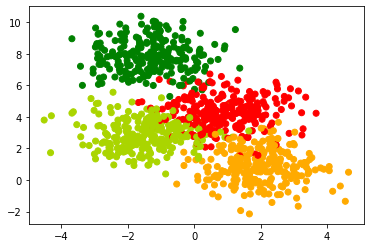

In [107]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [108]:
labels_orig = labels
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [109]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_Out_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_Out_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_Out_train.shape, y_Out_val.shape)

(750, 4) (250, 4)


In [110]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


In [111]:
class Vectorised_FFNN:

  def __init__(self,W1,W2):

    self.params={}
    self.params["W1"]=W1.copy()
    self.params["W2"]=W2.copy()
    self.params["B1"]=np.zeros((1,2))
    self.params["B2"]=np.zeros((1,4))
    self.num_layers=2
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0

  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))

  def grad_sigmoid(self, X):
    return X*(1-X)
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self,X,params = None):
    if params is None:
        params = self.params
    
    self.A1 = np.matmul(X, params["W1"]) + params["B1"]
    self.H1 = self.sigmoid(self.A1)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] 
    self.H2 = self.softmax(self.A2)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y
    self.gradients["dW2"] = np.matmul(self.H1.T , self.gradients["dA2"])
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"] , params["W2"].T)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_sigmoid(self.H1))
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1)
  
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
    if display_loss:
      loss = {}

    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]

      if algo == "GD":
        self.grad(X,Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
      
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]
      
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
      

      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    if display_loss:
      Values = np.array(list(loss.values())).astype(float)
      plt.plot(Values, '-o', markersize=5)
      #plt.plot(loss.values(), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()



In [112]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


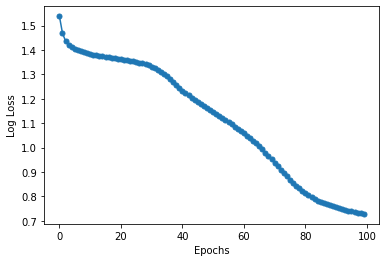

Training accuracy 0.7053
Validation accuracy 0.716
CPU times: user 380 ms, sys: 9.63 ms, total: 389 ms
Wall time: 409 ms


In [113]:
%%time
model = Vectorised_FFNN(W1, W2)
model.fit(X_train, y_Out_train, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


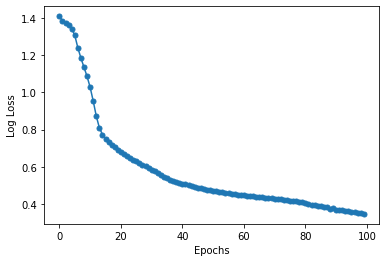

Training accuracy 0.8867
Validation accuracy 0.904
CPU times: user 414 ms, sys: 7.56 ms, total: 422 ms
Wall time: 428 ms


In [114]:
%%time
model = Vectorised_FFNN(W1, W2)
model.fit(X_train, y_Out_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


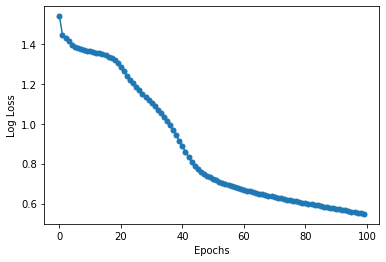

Training accuracy 0.8387
Validation accuracy 0.852
CPU times: user 372 ms, sys: 11.7 ms, total: 384 ms
Wall time: 400 ms


In [115]:
%%time
model = Vectorised_FFNN(W1, W2)
model.fit(X_train, y_Out_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


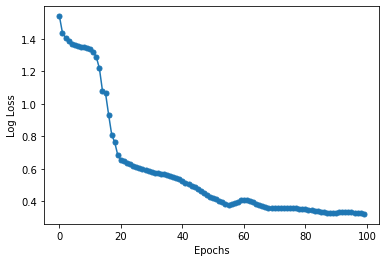

Training accuracy 0.88
Validation accuracy 0.872
CPU times: user 370 ms, sys: 5.79 ms, total: 376 ms
Wall time: 378 ms


In [116]:
%%time
model = Vectorised_FFNN(W1, W2)
model.fit(X_train, y_Out_train, epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


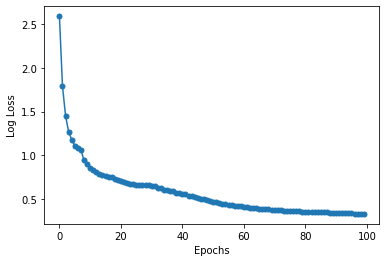

Training accuracy 0.88
Validation accuracy 0.904
CPU times: user 365 ms, sys: 10.3 ms, total: 376 ms
Wall time: 384 ms


In [117]:
%%time
model = Vectorised_FFNN(W1, W2)
model.fit(X_train, y_Out_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


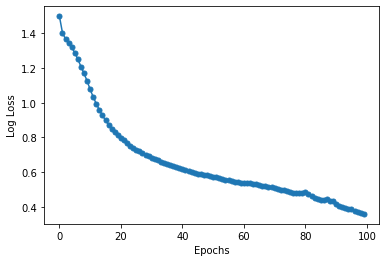

Training accuracy 0.8827
Validation accuracy 0.908
CPU times: user 355 ms, sys: 7.95 ms, total: 363 ms
Wall time: 369 ms


In [118]:
%%time
model = Vectorised_FFNN(W1, W2)
model.fit(X_train, y_Out_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


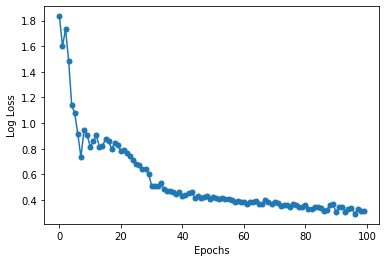

Training accuracy 0.8973
Validation accuracy 0.884
CPU times: user 489 ms, sys: 8.13 ms, total: 498 ms
Wall time: 505 ms


In [119]:
%%time
model = Vectorised_FFNN(W1, W2)
model.fit(X_train, y_Out_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()